In [1]:
import numpy as np
import pandas as pd

data = pd.read_excel('主力合约绘图.xlsx').drop(columns=['代码', '名称']).set_index('日期')
data

,开盘价(元),最高价(元),最低价(元),收盘价(元),结算价,成交额(百万),成交量,持仓量
日期,,,,,,,,
2004-09-22,1230,1235,1190,1191,1203,1875.07,155816,50352
2004-09-23,1181,1183,1172,1176,1178,876.71,74392,50162
2004-09-24,1165,1185,1165,1179,1179,692.56,58734,49068
2004-09-27,1191,1192,1159,1159,1169,958.59,81988,64722
2004-09-28,1159,1171,1159,1165,1165,622.16,53362,65830
...,...,...,...,...,...,...,...,...
2022-05-23,3005,3008,2982,2984,2993,12195.08,407377,1247421
2022-05-24,2984,2989,2953,2955,2969,13784.54,464164,1239299
2022-05-25,2954,2966,2923,2943,2942,18660.74,634173,1231195


In [2]:
mon_lst = ['09', '10', '11', '12']
data1 = pd.read_excel('玉米连一.xlsx')
data1['month'] = data1['日期'].apply(lambda x: x.strftime("%m"))
data1['ret'] = data1['收盘价(元)'].pct_change()
data1 = data1[data1['month'].apply(lambda x: x in mon_lst)].drop(columns=['代码', '名称']).set_index('日期')['ret'].dropna()

mon_lst = ['01', '02', '03', '04']
data5 = pd.read_excel('玉米连五.xlsx')
data5['month'] = data5['日期'].apply(lambda x: x.strftime("%m"))
data5['ret'] = data5['收盘价(元)'].pct_change()
data5 = data5[data5['month'].apply(lambda x: x in mon_lst)].drop(columns=['代码', '名称']).set_index('日期')['ret'].dropna()

mon_lst = ['05', '06', '07', '08']
data9 = pd.read_excel('玉米连九.xlsx')
data9['month'] = data9['日期'].apply(lambda x: x.strftime("%m"))
data9['ret'] = data9['收盘价(元)'].pct_change()
data9 = data9[data9['month'].apply(lambda x: x in mon_lst)].drop(columns=['代码', '名称']).set_index('日期')['ret'].dropna()


<AxesSubplot:ylabel='Frequency'>

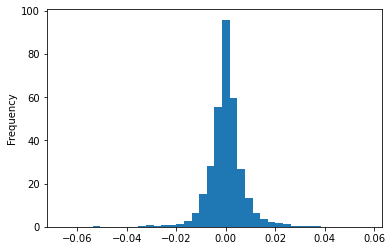

In [3]:
data = pd.concat([data1, data5, data9])
data.plot(kind='hist', bins=40, density=True)

In [ ]:
data.describe()

In [4]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='exponential', bandwidth=0.001).fit(data.values.reshape(-1, 1))

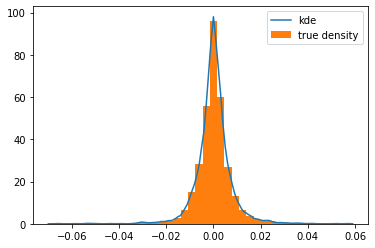

In [5]:
import matplotlib.pyplot as plt

x = np.arange(-0.07, 0.06, 0.001)
y = np.exp(kde.score_samples(x.reshape(-1, 1)))
plt.plot(x, y, label='kde')
plt.hist(data, 40, density=True, label='true density')
plt.legend()

In [190]:
from scipy.stats import norm
import random
import tqdm

def dist_prob(theta):
    if type(theta) is float:
        theta = np.array([theta])
    y = np.exp(kde.score_samples(theta.reshape(-1, 1)))
    return y

T = 590000
pi = [0.1 for i in range(T)]
sigma = 1
t = 0
for t in tqdm.tqdm(range(T-1)):
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = min(1, (dist_prob(pi_star[0]) / dist_prob(pi[t - 1])))   #alpha值

    u = random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]




100%|██████████| 589999/589999 [05:10<00:00, 1899.12it/s]


In [207]:
plt.scatter(pi, dist_prob(np.array(pi)),label='Target Distribution')
num_bins = 60
plt.hist(pi, num_bins, density=True, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

In [194]:
random.shuffle(pi)

In [199]:
S = 2864
r_simulate = pd.DataFrame(np.array(pi).reshape(59, -1))
r_simulate = 2864 * (r_simulate+1).cumprod().iloc[-1, :]

In [204]:
def opt_return(ST, K):
    return np.max([0, ST-K])
r_simulate.apply(lambda x: opt_return(x, 2864)).mean()

71.41478216996018